In [23]:
import torch
import torchvision
import torchvision.transforms as transforms

import cv2

print(cv2.__version__)

4.0.1


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


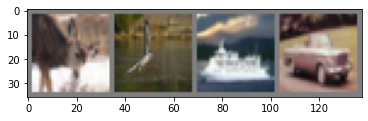

 deer  bird  ship   car


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def to_np_img(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


def imshow(img):
    plt.imshow(to_np_img(img))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [21]:
key_point_det = cv.SIFT_create(nfeatures=2500)  
    
kp_target, des_target = key_point_det.detectAndCompute(to_np_img(images[0]),None)



AttributeError: module 'cv2' has no attribute 'SIFT_create'

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

cuda:0
[1,  2000] loss: 2.222
[1,  4000] loss: 1.880
[1,  6000] loss: 1.713
[1,  8000] loss: 1.628
[1, 10000] loss: 1.530
[1, 12000] loss: 1.482
[2,  2000] loss: 1.397
[2,  4000] loss: 1.387
[2,  6000] loss: 1.352
[2,  8000] loss: 1.350
[2, 10000] loss: 1.301
[2, 12000] loss: 1.288
[3,  2000] loss: 1.223
[3,  4000] loss: 1.204
[3,  6000] loss: 1.190
[3,  8000] loss: 1.191
[3, 10000] loss: 1.190
[3, 12000] loss: 1.203
[4,  2000] loss: 1.074
[4,  4000] loss: 1.098
[4,  6000] loss: 1.118
[4,  8000] loss: 1.091
[4, 10000] loss: 1.107
[4, 12000] loss: 1.083
[5,  2000] loss: 1.020
[5,  4000] loss: 1.006
[5,  6000] loss: 1.033
[5,  8000] loss: 1.019
[5, 10000] loss: 1.045
[5, 12000] loss: 1.020
[6,  2000] loss: 0.930
[6,  4000] loss: 0.977
[6,  6000] loss: 0.962
[6,  8000] loss: 0.986
[6, 10000] loss: 0.972
[6, 12000] loss: 1.001
[7,  2000] loss: 0.881
[7,  4000] loss: 0.893
[7,  6000] loss: 0.920
[7,  8000] loss: 0.925
[7, 10000] loss: 0.945
[7, 12000] loss: 0.932
[8,  2000] loss: 0.845
[8, 

In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

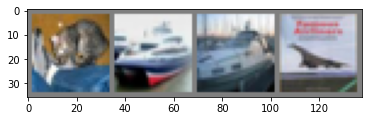

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %
